### Cancer Cell Detection With CNNs

This project is about detecting cancerous cells in images of cell biospsies. It is a supervised binary classifcation problem.

The data are images of the potentially cancerous cells. 

The full training set consists of 220,025 examples of 96 X 96 pixel images. Each image either is a cell biopsy that is or is not cancerous. The binary label is whether the image depicts a cancerous biopsy or not.

To start, we will do some EDA and preprocessing of the data to get it formatted properly for the analysis. Then we will test two different model architectures and experiment with tuning some of the hyperparameters. The images are a large dataset that takes a long time to train, so we will be somewhat limited by available compute power, as with all problems of this type.

Achieving the highest accuracy on the (unlabeled) test set is our ultimate goal. The final models will be evaluated on the test set once the predictions are submitted to the competition. The Test Set consists of 57,458 images whose labels are hidden from us.

In [4]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.transform import rotate
from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
#from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For reproducibility
random_state = 12

%matplotlib inline

### Exploratory Data Analysis and Data Preparation

Look at distribution of classes in train set, as well as understand the type of data we're working with. The training data is just the images without any associated metadata. Thus our ability to do feature engineering is limited and would need to extract information out of the images themselves. 

Test set labels are hidden for evaluating submissions to the kaggle competition. 

In [21]:
train_labels =  pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(f"There are are {len(train_labels)} examples in the training data.")
train_labels.head()

There are are 220025 examples in the training data.


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


There are are 22002 examples in the subsampled training data.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


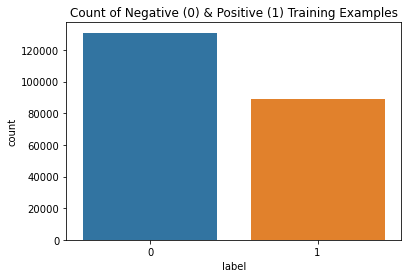

0    13004
1     8998
Name: label, dtype: int64

In [22]:
# Create subsample training set for faster iteration
train_labels_sub = train_labels.sample(frac = 0.1, random_state=random_state)
print(f"There are are {len(train_labels_sub)} examples in the subsampled training data.")

plt.title('Count of Negative (0) & Positive (1) Training Examples')
sns.countplot(train_labels.label)
plt.show();

train_labels_sub.label.value_counts()

Train set is 220025 images, Test set is 57458 images.
TIFF
(96, 96)
RGB


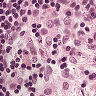

In [9]:
train_loc = '/kaggle/input/histopathologic-cancer-detection/train'
test_loc = '/kaggle/input/histopathologic-cancer-detection/test'

# Load in training pictures 
ims_train = [(os.path.join(train_loc, filename)) for filename in os.listdir(train_loc)]
ims_test = [(os.path.join(test_loc, filename)) for filename in os.listdir(test_loc)]

# Check for duplicates
assert len(np.unique(ims_train)) == len(ims_train), 'There are duplicates in train set'
assert len(np.unique(ims_test)) == len(ims_test), 'There are duplicates in test set'

print(f"Train set is {len(ims_train)} images, Test set is {len(ims_test)} images.")

example_image = Image.open(ims_train[100])

# summarize some details about the images
print(example_image.format)
print(example_image.size)
print(example_image.mode)

# show the image
example_image

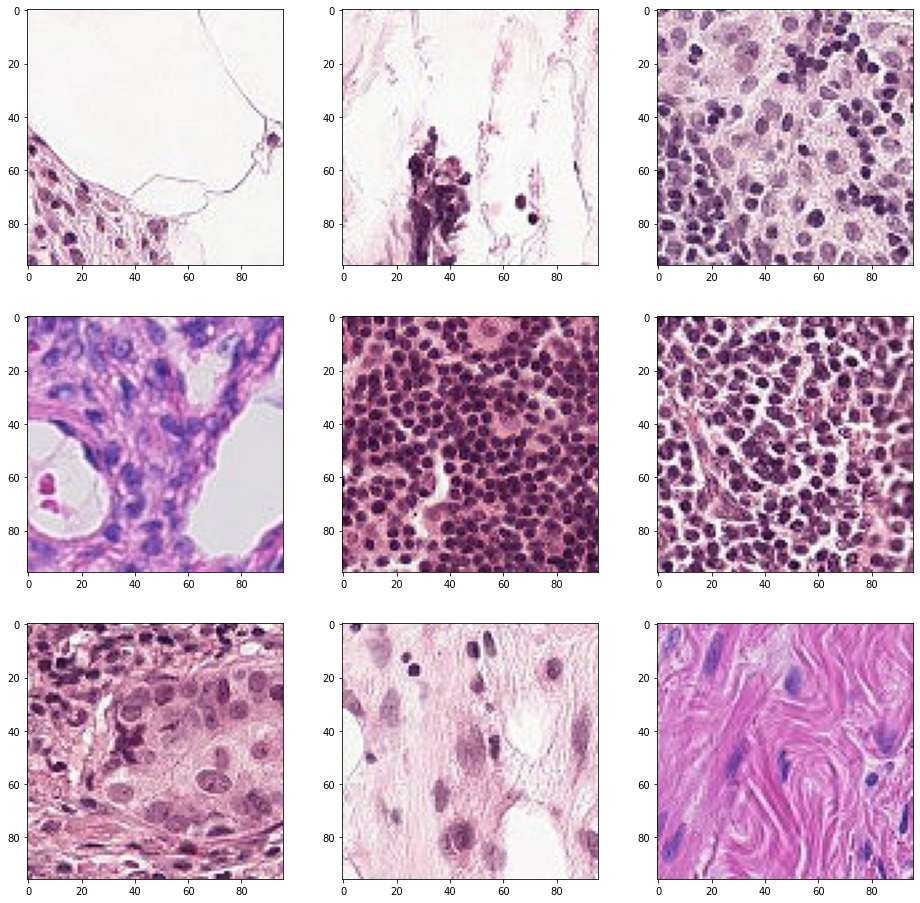

In [6]:
#Image Visualisations
#from io import imread

fig, ax = plt.subplots(3,3, figsize=(16, 16))
for im, axis in enumerate(ax.flat):
    path = str(train_loc + '/' + train_labels.id[im] + '.tif')
    example_image = io.imread(path)
    axis.imshow(example_image)
    #axis.set(xticks=[], yticks=[], xlabel = train_data.label[i]);

Looking at a few example images to understand what the data looks like, we can see the data are 96 X 96 X 3 RGB images in TIFF format. We can also see there are no duplicates in the training or test data.

There is not much else we can do in terms of EDA or cleaning without doing some fairly complex image analysis, which is out of scope for this project. We'll instead focus on the model architecture, hyperparameters and other methods of improving performance in Computer Vision models. 

### Pre-Process Data For Training

We'll resize the images to 64 X 64 to improve training speed. Also the batch size is fairly large at 256. 

In [23]:
# Convert label column to string for the data generator
train_labels_sub['label'] = train_labels_sub['label'].astype(str)
assert '.tif' not in train_labels_sub['id'].iloc[0], 'already added t.f suffix'
train_labels_sub['id'] = train_labels_sub['id'].apply(lambda x: x + '.tif')

train_labels['label'] = train_labels['label'].astype(str)
assert '.tif' not in train_labels['id'].iloc[0], 'already added t.f suffix'
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

In [24]:
# Create data generator from label dataframe
# Normalize pixels by dividing by 255. Create 20% Validation Split

data_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.20)

gen_validation = data_gen.flow_from_dataframe(train_labels,
                                          directory = train_loc,
                                          x_col = 'id',
                                          y_col = 'label',
                                          batch_size = 256,
                                          subset = 'validation',
                                          class_mode = 'binary',
                                          seed = 12,
                                          target_size = (64,64))

gen_validation

Found 44005 validated image filenames belonging to 2 classes.


In [25]:

gen_train = data_gen.flow_from_dataframe(train_labels,
                                          directory = train_loc,
                                          x_col = 'id',
                                          y_col = 'label',
                                          subset = 'training',
                                          batch_size = 256,
                                          class_mode = 'binary',
                                          seed = 12,
                                          target_size = (64,64))
gen_train

Found 176020 validated image filenames belonging to 2 classes.



## Analysis - Train CNN Models of Increasing Complexity

For this project I chose to train 3 models with increasing complexity in terms of convolutional layers and number of filters. I tried to choose a generic CNN architecture that could be scaled up to test the hypothesis that models of increasing complexity can achieve better scores. Each model includes an added convolutional block with 3 CNN layers.

Because this is a very large training dataset, to keep training time reasonable I limited training to 12 epochs. To keep it simple I also kept the same optimizer (Adam) and learning rate (0.001) through each model. We'll test out optimizing the learning rate later on. 

### Simple CNN

This is a fairly simple model with three convolutional layers, max pooling, and aa final dense layer. Dropout regularization is applied to limit overfitting.


In [11]:
n_filters = [32, 64, 128]

model_CNN_simplest = Sequential()
model_CNN_simplest.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu', input_shape = (64, 64, 3)))  
model_CNN_simplest.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN_simplest.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN_simplest.add(MaxPooling2D(pool_size = (2,2))) 
model_CNN_simplest.add(Dropout(0.25))

model_CNN_simplest.add(Flatten())
model_CNN_simplest.add(Dense(256, activation = "relu"))
model_CNN_simplest.add(Dropout(0.25))
model_CNN_simplest.add(Dense(1, activation='sigmoid'))


opt = Adam(learning_rate=0.001)
ROC = tf.keras.metrics.AUC()
model_CNN_simplest.compile(loss='binary_crossentropy', metrics=['accuracy', ROC], optimizer=opt)

model_CNN_simplest.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [12]:
CNN1 = model_CNN_simplest.fit(
                        gen_train,
                        epochs = 12,
                        validation_data = gen_validation)

model_CNN_simplest.save('simple_cnn_0001_full')

Epoch 1/12
688/688 [==============================] - 1061s 2s/step - loss: 0.5289 - accuracy: 0.7734 - auc_1: 0.8334 - val_loss: 0.4822 - val_accuracy: 0.8024 - val_auc_1: 0.8704
Epoch 2/12
688/688 [==============================] - 319s 464ms/step - loss: 0.4505 - accuracy: 0.8158 - auc_1: 0.8797 - val_loss: 0.4303 - val_accuracy: 0.8230 - val_auc_1: 0.8952
Epoch 3/12
688/688 [==============================] - 284s 413ms/step - loss: 0.4036 - accuracy: 0.8353 - auc_1: 0.9018 - val_loss: 0.3628 - val_accuracy: 0.8458 - val_auc_1: 0.9162
Epoch 4/12
688/688 [==============================] - 302s 439ms/step - loss: 0.3513 - accuracy: 0.8531 - auc_1: 0.9216 - val_loss: 0.3258 - val_accuracy: 0.8615 - val_auc_1: 0.9329
Epoch 5/12
688/688 [==============================] - 283s 412ms/step - loss: 0.3270 - accuracy: 0.8640 - auc_1: 0.9328 - val_loss: 0.3189 - val_accuracy: 0.8647 - val_auc_1: 0.9361
Epoch 6/12
688/688 [==============================] - 281s 408ms/step - loss: 0.3031 - accur

Best Val Acc: 0.88 on epoch 8 with training accuracy of 0.898


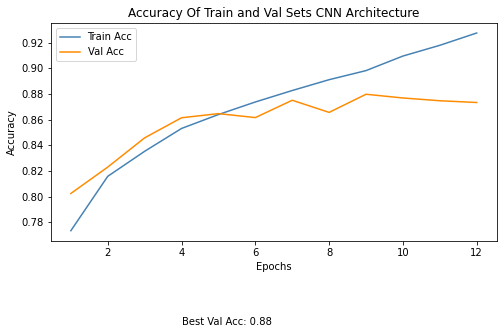

In [15]:
best_acc_epoch = 9
for i in range(12):
    if CNN1.history['val_accuracy'] == max(CNN1.history['val_accuracy']):
        best_acc_epoch = i

plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets CNN Architecture')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(CNN1.history['val_accuracy']):.3} on epoch {best_acc_epoch} with training accuracy of {CNN1.history['accuracy'][best_acc_epoch]:.3}")
    
plt.plot(range(1, len(CNN1.history['accuracy']) + 1), CNN1.history['accuracy'], 'steelblue');
plt.plot(range(1, len(CNN1.history['val_accuracy']) + 1), CNN1.history['val_accuracy'], 'darkorange')
plt.text(4, 0.7, f"Best Val Acc: {max(CNN1.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

### Moderate Complexity CNN

This is a moderately complex CNN model with six total convolutional layers, max pooling, and a final dense layer. Dropout regularization is applied after each block of convolutional layers to limit overfitting.

In [40]:
n_filters = [32, 64, 128]

model_CNN_med_complexity = Sequential()
model_CNN_med_complexity.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu', input_shape = (64, 64, 3)))  
model_CNN_med_complexity.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN_med_complexity.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN_med_complexity.add(MaxPooling2D(pool_size = (2,2))) 
model_CNN_med_complexity.add(Dropout(0.25))

model_CNN_med_complexity.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN_med_complexity.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN_med_complexity.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN_med_complexity.add(MaxPooling2D(pool_size = (2,2)))
model_CNN_med_complexity.add(Dropout(0.25))

model_CNN_med_complexity.add(Flatten())
model_CNN_med_complexity.add(Dense(256, activation = "relu"))
model_CNN_med_complexity.add(Dropout(0.25))
model_CNN_med_complexity.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.001)
ROC = tf.keras.metrics.AUC()
model_CNN_med_complexity.compile(loss='binary_crossentropy', metrics=['accuracy', ROC], optimizer=opt)

model_CNN_med_complexity.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 64)       

In [ ]:
CNN2 = model_CNN_med_complexity.fit(
                        gen_train,
                        epochs = 12,
                        validation_data = gen_validation)

model_CNN_med_complexity.save('moderate_cnn_001_full')

Epoch 1/12
688/688 [==============================] - 424s 616ms/step - loss: 0.4436 - accuracy: 0.8003 - auc_2: 0.8684 - val_loss: 0.3893 - val_accuracy: 0.8241 - val_auc_2: 0.9082
Epoch 2/12
688/688 [==============================] - 284s 412ms/step - loss: 0.3629 - accuracy: 0.8428 - auc_2: 0.9143 - val_loss: 0.3366 - val_accuracy: 0.8514 - val_auc_2: 0.9284
Epoch 3/12
688/688 [==============================] - 272s 395ms/step - loss: 0.3259 - accuracy: 0.8609 - auc_2: 0.9313 - val_loss: 0.3484 - val_accuracy: 0.8438 - val_auc_2: 0.9397
Epoch 4/12
688/688 [==============================] - 267s 389ms/step - loss: 0.3040 - accuracy: 0.8725 - auc_2: 0.9404 - val_loss: 0.2776 - val_accuracy: 0.8850 - val_auc_2: 0.9497
Epoch 5/12
688/688 [==============================] - 272s 396ms/step - loss: 0.2661 - accuracy: 0.8902 - auc_2: 0.9541 - val_loss: 0.2527 - val_accuracy: 0.8987 - val_auc_2: 0.9586
Epoch 7/12
688/688 [==============================] - 289s 419ms/step - loss: 0.2564 - acc

### Most Complex CNN

This is a highly complex model with nine total convolutional layers, max pooling, and a final dense layer. Dropout regularization is applied after each block of convolutional layers.

In [19]:
n_filters = [32, 64, 128]

model_CNN = Sequential()
model_CNN.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu', input_shape = (64, 64, 3)))  
model_CNN.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2))) 
model_CNN.add(Dropout(0.25))

model_CNN.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Conv2D(n_filters[2], kernel_size = (3,3), activation ='relu'))
model_CNN.add(Conv2D(n_filters[2], kernel_size = (3,3), activation ='relu'))
model_CNN.add(Conv2D(n_filters[2], kernel_size = (3,3), activation ='relu'))
model_CNN.add(MaxPooling2D(pool_size = (2,2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Flatten())
model_CNN.add(Dense(256, activation = "relu"))
model_CNN.add(Dropout(0.25))
model_CNN.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.001)
ROC = tf.keras.metrics.AUC()
model_CNN.compile(loss='binary_crossentropy', metrics=['accuracy', ROC], optimizer=opt)

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 64)       

In [27]:
# Train the complex CNN Model
training_progress_CNN = model_CNN.fit(
                        gen_train,
                        epochs = 12,
                        validation_data = gen_validation)

Epoch 1/12
688/688 [==============================] - 798s 1s/step - loss: 0.3952 - accuracy: 0.8284 - auc: 0.8962 - val_loss: 0.3766 - val_accuracy: 0.8329 - val_auc: 0.9169
Epoch 2/12
688/688 [==============================] - 308s 447ms/step - loss: 0.3508 - accuracy: 0.8503 - auc: 0.9191 - val_loss: 0.3281 - val_accuracy: 0.8604 - val_auc: 0.9353
Epoch 3/12
688/688 [==============================] - 277s 402ms/step - loss: 0.3170 - accuracy: 0.8669 - auc: 0.9343 - val_loss: 0.3177 - val_accuracy: 0.8654 - val_auc: 0.9463
Epoch 4/12
688/688 [==============================] - 272s 395ms/step - loss: 0.2937 - accuracy: 0.8773 - auc: 0.9436 - val_loss: 0.2871 - val_accuracy: 0.8829 - val_auc: 0.9473
Epoch 5/12
688/688 [==============================] - 274s 399ms/step - loss: 0.2820 - accuracy: 0.8839 - auc: 0.9482 - val_loss: 0.3214 - val_accuracy: 0.8693 - val_auc: 0.9466
Epoch 6/12
688/688 [==============================] - 268s 390ms/step - loss: 0.2660 - accuracy: 0.8908 - auc: 0.

In [ ]:
model_CNN.save('moost_complex_cnn_001_full')

Best Val Acc: 0.908 on epoch 12 with training accuracy of 0.907


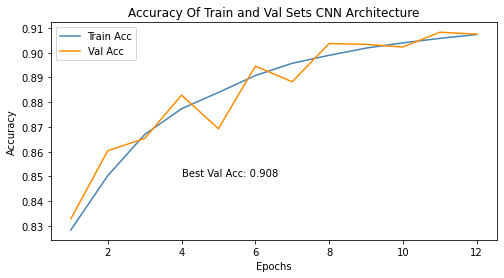

In [32]:
best_acc_epoch = 11
for i in range(12):
    if training_progress_CNN.history['val_accuracy'] == max(training_progress_CNN.history['val_accuracy']):
        best_acc_epoch = i

plt.figure(figsize=(8,4))
plt.title(f'Accuracy Of Train and Val Sets CNN Architecture')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(training_progress_CNN.history['val_accuracy']):.3} on epoch {best_acc_epoch + 1} with training accuracy of {training_progress_CNN.history['accuracy'][best_acc_epoch]:.3}")
    
plt.plot(range(1, len(training_progress_CNN.history['accuracy']) + 1), training_progress_CNN.history['accuracy'], 'steelblue');
plt.plot(range(1, len(training_progress_CNN.history['val_accuracy']) + 1), training_progress_CNN.history['val_accuracy'], 'darkorange')
plt.text(4, 0.85, f"Best Val Acc: {max(training_progress_CNN.history['val_accuracy']):.3}" )
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

#### Tuning Learning Rate Hyperparamter

Hyper-parametere optimization can be a tricky and non-intuitive business. Because the trining dataset is so large, we will use a 20% subset of the training data to optimize the learning rate. The best learning rate will be evaluated as the best accuract on the validation set after 20 training epochs. We can also look at the plots of training and validation accuracy across epochs to see how well and quickly the model is able to learn with each optimizer. 

In [41]:
data_gen = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.20)

gen_validation = data_gen.flow_from_dataframe(train_labels_sub,
                                          directory = train_loc,
                                          x_col = 'id',
                                          y_col = 'label',
                                          batch_size = 256,
                                          subset = 'validation',
                                          class_mode = 'binary',
                                          seed = 12,
                                          target_size = (64,64))

gen_train = data_gen.flow_from_dataframe(train_labels_sub,
                                          directory = train_loc,
                                          x_col = 'id',
                                          y_col = 'label',
                                          batch_size = 256,
                                          subset = 'training',
                                          class_mode = 'binary',
                                          seed = 12,
                                          target_size = (64,64))


Found 4400 validated image filenames belonging to 2 classes.
Found 17602 validated image filenames belonging to 2 classes.


In [42]:
# Test with moderate complexity model.
n_filters = [32, 64, 128]

test_mod = Sequential()
test_mod.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu', input_shape = (64, 64, 3)))  
test_mod.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
test_mod.add(Conv2D(n_filters[0], kernel_size = (3,3), activation = 'relu'))
test_mod.add(MaxPooling2D(pool_size = (2,2))) 
test_mod.add(Dropout(0.25))

test_mod.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
test_mod.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
test_mod.add(Conv2D(n_filters[1], kernel_size = (3,3), activation ='relu'))
test_mod.add(MaxPooling2D(pool_size = (2,2)))
test_mod.add(Dropout(0.25))

test_mod.add(Flatten())
test_mod.add(Dense(256, activation = "relu"))
test_mod.add(Dropout(0.25))
test_mod.add(Dense(1, activation='sigmoid'))

Best Val Acc: 0.816 at epoch 0 with learning rate of 0.0001


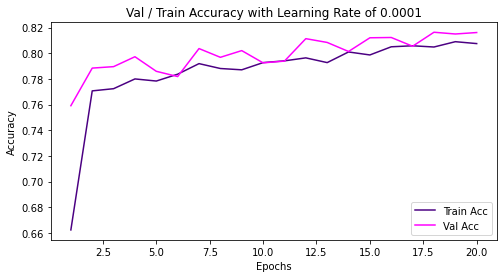

Best Val Acc: 0.851 at epoch 0 with learning rate of 0.001


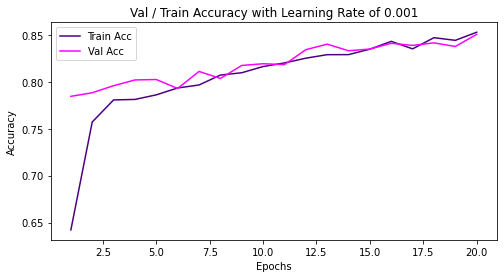

Best Val Acc: 0.589 at epoch 0 with learning rate of 0.01


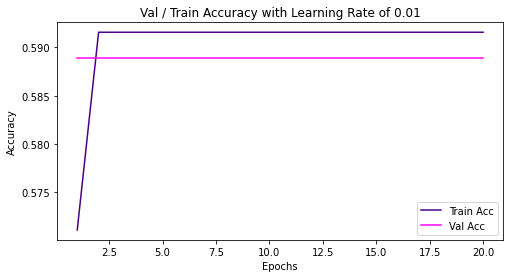

In [43]:
# Optimize Learning Rate Hyperparameter For Adam Optimizer   
model = test_mod

best_val_accuracies = []
lowest_val_loss = []
best_epoch = []
train_accuracy  = []
train_loss = []

for lr in [0.0001, 0.001, 0.01]:
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
    history = model.fit(gen_train, epochs=20, validation_data= gen_validation, verbose=0)
    
    best_acc = max(history.history['val_accuracy'])
    best_acc_epoch = 0
    for i in range(len(history.history)):
        if history.history['val_accuracy'] == best_acc:
            best_acc_epoch = i
    best_epoch.append(best_acc_epoch)
    best_val_accuracies.append(best_acc)
    lowest_val_loss.append(max(history.history['val_loss']))
    train_accuracy.append(history.history['accuracy'][best_acc_epoch]) 
    train_loss.append(history.history['loss'][best_acc_epoch])
    
    print(f"Best Val Acc: {max(history.history['val_accuracy']):.3} at epoch {best_acc_epoch} with learning rate of {lr}")
    plt.figure(figsize=(8,4))
    plt.title(f'Val / Train Accuracy with Learning Rate of {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], 'indigo');
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], 'magenta')
    plt.legend(['Train Acc', 'Val Acc'])
    plt.show()


### Results - Model Training and Hyperparameter Tuning

The results of submitting the final predictions to the competition were:

* Simplest Model: 0.7921
* Moderate Complexity Model: 0.8352
* Very Complex Model: 0.7995

The moderately complex model did the best with a test set score of 0.8352. You can see the result on the Kaggle leaderboard screenshot.

The least complex model performed the worst. It was likely too simple of a model to effectively repressent the data, and you can see evidence of this in the training/validation graph from the training run, where the validatin and training accuracy diverge across epochs. 

The moderately complex model likely did the best because it was complex enough to learn the data but not so complex as to overfit on the training data. It's possible additional training epochs and further hyperparameter tuning could produce a higher score.

During training the most complex model seemed to do a little better, but it possibly overfit and was not able to generalize as well to the test data, though it was fairly close to the moderately complex in performance. Better regularization, more training epochs and some hyperparameter tuning could make this model the best scorer after some further work. 


The results of the learning reat hyperparamter tuning experiment were:

* The learning rate of 0.0001 allowed the model to easily learn, but training was slow. 

* The learning rate of 0.001 also allowed the model to easily learn and was further along after 20 epochs with a better accuracy. 

* The learning rate of 0.01 had terrible results, as you can see in the graph of validation and training accuracy across epochs. The model was simply not able to learn with such a high learning rate.

It seems the choice of a 0.001 learning rate for the default in all of my model training runs was appropriate.

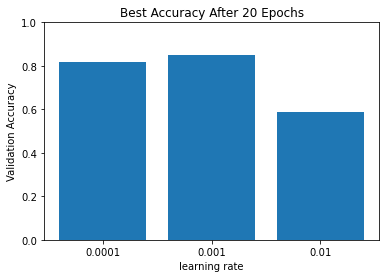

In [45]:
# bar chart of learning rate experiment results.
plt.bar(['0.0001', '0.001', '0.01'], [0.816, 0.851,0.589])
plt.title('Best Accuracy After 20 Epochs')
plt.xlabel('learning rate')
plt.ylabel('Validation Accuracy')
plt.ylim(0,1)
plt.show()

### Code For Preparing Submission

In [ ]:
test_gen = ImageDataGenerator(rescale=1.0/255, )

test_generator = test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_loc,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

In [39]:
# Creat predictions for submission
predictions = model_CNN.predict(test_generator, verbose=1)

predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()

submission_df['id'] = ims_test['id'].apply(lambda x: x.split('.')[0].split('/')[-1])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.to_csv('complex_model.csv', index=False)

57458/57458 [==============================] - 198s 3ms/step


In [40]:
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


### Conclusions and Discussion

This was a great project for learning about computer vision. It was also a very large set of data that needed accelerators and special handling to train models in any kind of reasonable time. I could work on this for weeks to get a better score if I really wanted. 

All models performed fairly well on the test predictions, but my moderately complex architecture performed the best.

Ideas for future improvement:
* Try out diffferent model architectures and combinations of dense and connected layers.
* Experiment with different types and rates of regularization.
* More training epochs in combination with appropriate regularization to avoid overfitting t the training data.
* Transfer learning from a ResNet or similar pretrained model to speed up training and get better results faster. 